In [1]:
import torch
from torch import nn

In [2]:
device  = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'mps'

__Downloading Dataset__

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path  = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} already exists')
else:
    print(f'{image_path} doesnt exist creating one .....')
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request  = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloadng data ......')
    f.write(request.content)

data/pizza_steak_sushi already exists
Downloadng data ......


In [7]:
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping Data ......')
    zip_ref.extractall(image_path)

Unzipping Data ......


__Exploring Data__

In [4]:
import os 

def walk_through_data(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [5]:
walk_through_data(image_path)

There are 2 directories and 1 images in data/pizza_steak_sushi.
There are 3 directories and 1 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 1 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


In [7]:
# Training and Testing data setup

train_dir =  image_path / 'train'
test_dir =  image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/test/steak/3873283.jpg
steak
Height 512, Width 512


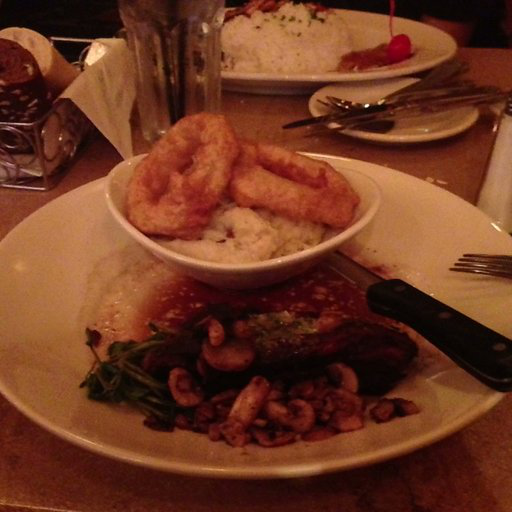

In [8]:
import random
from PIL import Image

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)


print(f'Height {img.height}, Width {img.width}')
img

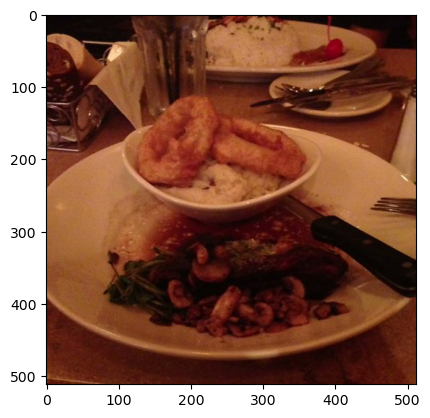

(512, 512, 3)


In [9]:
import matplotlib.pyplot as plt 
import numpy as np 

img_to_array = np.asarray(img)
plt.imshow(img_to_array)
plt.show()
print(img_to_array.shape)

__Turning Image(raw) into Pytorch Tensor__

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
data_transform = transforms.Compose([

    transforms.Resize(size=(64,64)),         # resize image to 64*64
    transforms.RandomHorizontalFlip(p=0.5),  # flip image randomly on the horizontal
    transforms.ToTensor()                    # turn image into torch tensor
])

In [12]:
print(data_transform(img).shape)
print(img.size)

torch.Size([3, 64, 64])
(512, 512)


In [13]:
def plot_transformed_image(image_path:list, transform, n=3, seed=None):

    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)
    for image_path in random_image_paths:

        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            # Plotting Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Size {f.size}')
            ax[0].axis(False)

            # Plotting Transformer Image
            transformed_image = transform(f).permute(1 ,2, 0)  # (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Size {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class : {image_path.parent.stem}')

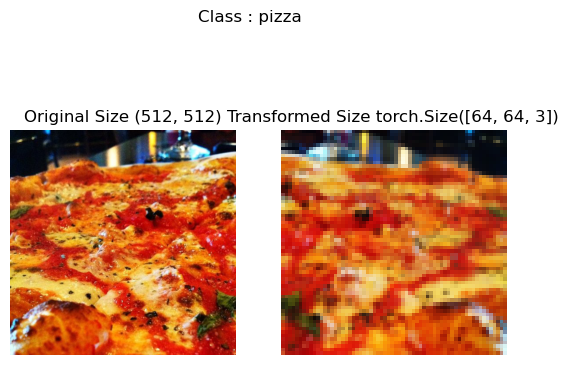

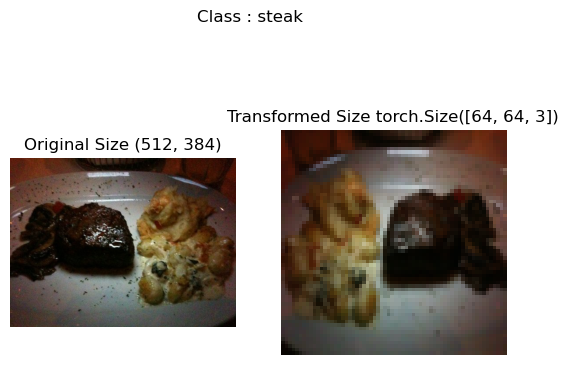

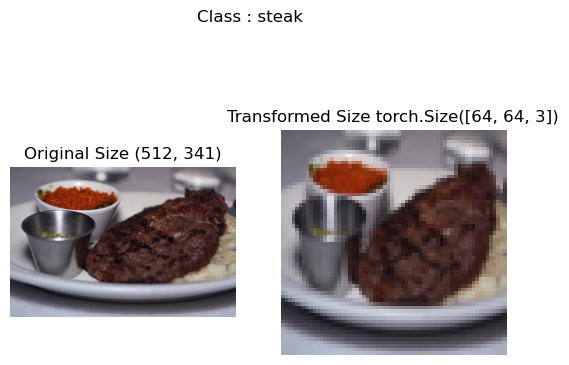

In [14]:
plot_transformed_image(image_path_list, data_transform, 3, 42)

__Option 1 : Loading Image data using `ImageFolder` in Pytorch__

In [17]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

In [18]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [24]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

print(class_names, class_dict)
print(len(train_data))
print(len(test_data))

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
225
75


In [23]:
train_data.targets[:5]

[0, 0, 0, 0, 0]

In [41]:
print(train_data[12][0].shape)
print(train_data[12][0].permute(1,2,0).shape)

torch.Size([3, 64, 64])
torch.Size([64, 64, 3])


__Note__

When we have image with single channel (that's means gray image) we can work with `img.squeeze()` and show the image with `plt.imshow` but when we have image with 3 channels then we have change the shape of Pytorch Tensor from (C, H, W) to (H, W, C) using `img.permute(1,2,0)`

Matplotlib expects images in HWC format.

Why (1, 64, 64) works with .squeeze() -> The image shape (1, 64, 64) becomes (64, 64) after squeeze(), Matplotlib sees a 2D array, so it assumes it’s grayscale

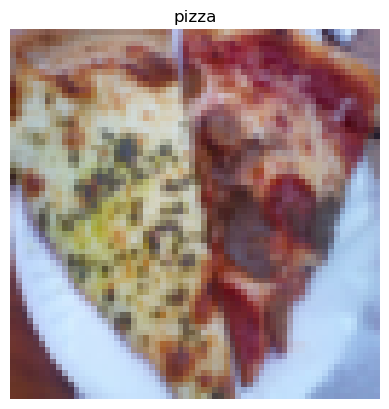

In [40]:
img, label = train_data[12][0], train_data[12][1]
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')
plt.show()

__Turning Image data into `DataLoader`__

In [51]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [53]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [55]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

__Creating Custom DataLoader__

In [56]:
import os 
import pathlib
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [63]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError('no dir inside')
    class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx


In [65]:
print(find_classes(train_dir))
print(find_classes(test_dir))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})
(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})
